<a href="https://colab.research.google.com/github/HaHyunkyung/Prediction-of-disabled-call-taxi-waiting-time/blob/main/%EC%A0%84%EC%B2%98%EB%A6%AC%2B%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <<< 데이터 전처리 >>>

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('open_data.csv')
weather = pd.read_csv('weather.csv')

In [ ]:
data['기준일'] = pd.to_datetime(data['기준일'])
weather['Date'] = pd.to_datetime(weather['Date'])
data.rename(columns={'기준일' : 'Date' , '평균대기시간' : 'M_Wating_Time'}, inplace=True)

df = data.copy()
df['year'] = data['Date'].dt.year
df['month'] = data['Date'].dt.month
df['day'] = data['Date'].dt.day
df['week'] = data['Date'].dt.isocalendar().week
df['day_name'] = data['Date'].dt.day_name()

In [ ]:
#내일의 날씨정보를 shift로 가져옴
weather['Date'].shift(1)

#target(내일의 평균대기시간)
df['tomorrow_wating_time'] = df['M_Wating_Time'].shift(-1)
df = df.dropna()

## 파생변수 추가

In [ ]:
data1 = pd.merge(df, weather, on='Date', how='inner')
data1['weekday'] = data1['Date'].dt.day_name()
data1['weekday'] = pd.Categorical(data1['weekday'],
                                  categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
data1['month'] = data1['Date'].dt.month

data1['season'] = np.where(data1['month'].isin([3,4,5]), 'Spring',
                           np.where(data1['month'].isin([6,7,8]), 'Summer',
                                    np.where(data1['month'].isin([9,10,11]), 'Fall', 'Winter')))
data1['season'] = pd.Categorical(data1['season'], categories=['Spring','Summer','Fall','Winter'])
data1['year'] = data1['Date'].dt.year



out = ['Date', 'tomorrow_wating_time']
data_target = data1[out]

In [ ]:
#공휴일 추가
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))
holiday = pd.DataFrame()
for y in range(2015, 2023) :
    holiday = pd.concat([holiday, pd.DataFrame(cal.holidays(y))], axis = 0)

holiday.columns = ['Date', 'holiday']
holiday['Date'] = pd.to_datetime(holiday['Date'])
holiday['holiday'] = 1
data0 = pd.merge(data1, holiday, how = 'left')
data1 = data0.fillna({'holiday':0})
data1.loc[data1['Date'] == '2015-08-14', 'holiday'] = 1
data1.loc[data1['Date'] == '2015-09-29', 'holiday'] = 1
data1.loc[data1['Date'] == '2016-02-10', 'holiday'] = 1
data1.loc[data1['Date'] == '2016-04-13', 'holiday'] = 1
data1.loc[data1['Date'] == '2016-05-06', 'holiday'] = 1
data1.loc[data1['Date'] == '2017-01-30', 'holiday'] = 1
data1.loc[data1['Date'] == '2017-05-09', 'holiday'] = 1
data1.loc[data1['Date'] == '2017-10-02', 'holiday'] = 1
data1.loc[data1['Date'] == '2017-10-06', 'holiday'] = 1
data1.loc[data1['Date'] == '2018-05-07', 'holiday'] = 1
data1.loc[data1['Date'] == '2018-06-13', 'holiday'] = 1
data1.loc[data1['Date'] == '2018-09-26', 'holiday'] = 1
data1.loc[data1['Date'] == '2019-05-06', 'holiday'] = 1
data1.loc[data1['Date'] == '2020-01-27', 'holiday'] = 1
data1.loc[data1['Date'] == '2020-04-15', 'holiday'] = 1
data1.loc[data1['Date'] == '2020-08-17', 'holiday'] = 1
data1.loc[data1['Date'] == '2021-08-16', 'holiday'] = 1
data1.loc[data1['Date'] == '2021-10-04', 'holiday'] = 1
data1.loc[data1['Date'] == '2021-10-11', 'holiday'] = 1
data1.loc[data1['Date'] == '2022-03-09', 'holiday'] = 1
data1.loc[data1['Date'] == '2022-06-01', 'holiday'] = 1
data1.loc[data1['Date'] == '2022-09-12', 'holiday'] = 1
data1.loc[data1['Date'] == '2022-10-10', 'holiday'] = 1

data1['탑승률'] = data1['탑승건'] / data1['접수건']
data1['7일 이동평균 대기시간'] = data1['M_Wating_Time'].rolling(window=7).mean()
data1.rename( columns=
    {
        '차량운행' : 'cases' ,
        '접수건' : 'bookings' ,
        '탑승건' : 'boardings' ,
        '평균요금' : 'average fare' ,
        '평균승차거리' : 'average distance' ,
        '7일 이동평균 대기시간' : '7-day moving average waiting time'   ,
        '탑승률' : 'boarding rate'
    }, inplace=True
)
data1['total_waiting']=data1['bookings']*data1['M_Wating_Time']

data1.to_csv('data1.csv')

### <<< 상관관계 확인 >>>

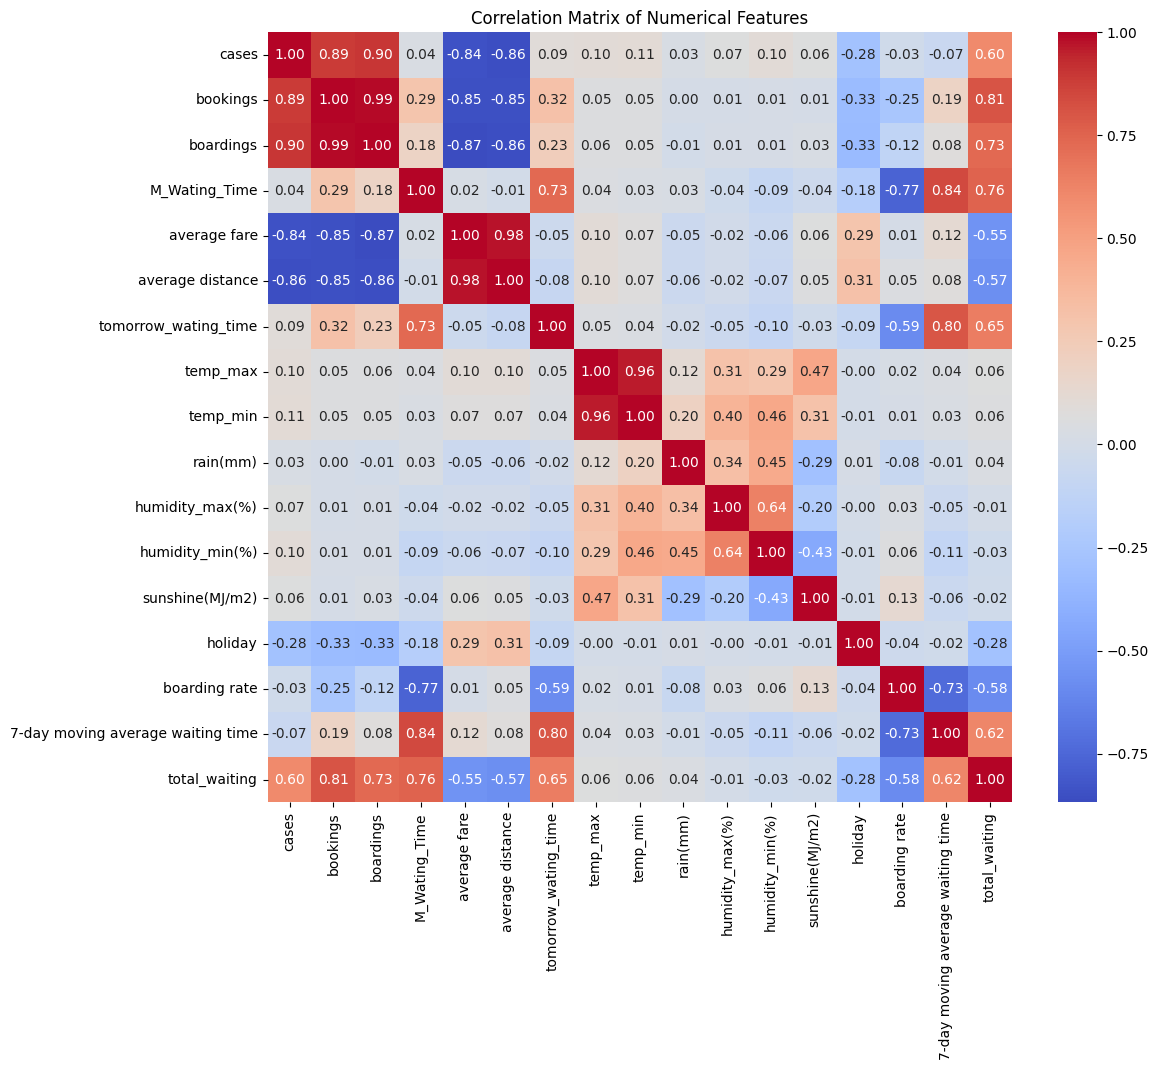

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns = data1.select_dtypes(include=['int64', 'float64']).columns

correlation_matrix = data1[numerical_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### <<< 모델링 >>>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import Lasso,ElasticNet,Ridge


In [ ]:
data = pd.read_csv('data1.csv')
data = data.dropna()


dump_cols = ['weekday', 'season', 'Date', 'day_name']
data = pd.get_dummies(data, columns=dump_cols, drop_first=True, dtype=int)
target = 'tomorrow_wating_time'
x = data.drop(target, axis=1)
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle= False, random_state=10)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_test)

model = RandomForestRegressor(n_estimators=180)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('mae : ', mean_absolute_error(y_test, y_pred))
print('mape : ', mean_absolute_percentage_error(y_test, y_pred))
print('r2_score : ', r2_score(y_test, y_pred))

mae :  4.865454603174603
mape :  0.16406470863712977
r2_score :  0.5761991500519755


### >>>>>하이퍼 파라미터 튜닝

In [ ]:
def main_task(n_components):
    model = RandomForestRegressor(n_estimators=n_components)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # print('mae : ', mean_absolute_error(y_test, y_pred))
    # print('mape : ', mean_absolute_percentage_error(y_test, y_pred))
    # print('r2_score : ', r2_score(y_test, y_pred))
    return r2_score(y_test, y_pred)

>>> n_estimators가 159일때 좋은 성능

In [ ]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
def optuna_main(trial: optuna.Trial):

    n_components = trial.suggest_int('n_components', 3, 500, step = 1)
    score = main_task(n_components=n_components)
    print('<<<score: ', score,  ' >>>>>')
    return score
study = optuna.create_study(direction='maximize')
study.optimize(optuna_main, n_trials=100)
print(f'study.best_trial.value : {study.best_trial.value}')
print(f'study.best_params : {study.best_trial.params}')


/home/mohee/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-20 11:57:25,617] A new study created in memory with name: no-name-c8acb8e9-73c2-47e3-a2e6-3108400fe86f
[I 2024-03-20 11:57:32,361] Trial 0 finished with value: 0.5722874445971424 and parameters: {'n_components': 78}. Best is trial 0 with value: 0.5722874445971424.


<<<score:  0.5722874445971424  >>>>>


[I 2024-03-20 11:57:47,376] Trial 1 finished with value: 0.5828582586124808 and parameters: {'n_components': 180}. Best is trial 1 with value: 0.5828582586124808.


<<<score:  0.5828582586124808  >>>>>


[I 2024-03-20 11:57:50,628] Trial 2 finished with value: 0.5554171666420407 and parameters: {'n_components': 40}. Best is trial 1 with value: 0.5828582586124808.


<<<score:  0.5554171666420407  >>>>>


[I 2024-03-20 11:58:12,416] Trial 3 finished with value: 0.5957127400004394 and parameters: {'n_components': 256}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5957127400004394  >>>>>


[I 2024-03-20 11:58:14,982] Trial 4 finished with value: 0.5615101853157536 and parameters: {'n_components': 31}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5615101853157536  >>>>>


[I 2024-03-20 11:58:22,041] Trial 5 finished with value: 0.5901325020995598 and parameters: {'n_components': 83}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5901325020995598  >>>>>


[I 2024-03-20 11:58:31,850] Trial 6 finished with value: 0.573486742444773 and parameters: {'n_components': 117}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.573486742444773  >>>>>


[I 2024-03-20 11:59:01,001] Trial 7 finished with value: 0.5890290837069408 and parameters: {'n_components': 322}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5890290837069408  >>>>>


[I 2024-03-20 11:59:31,444] Trial 8 finished with value: 0.5805419416136998 and parameters: {'n_components': 302}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5805419416136998  >>>>>


[I 2024-03-20 12:00:03,897] Trial 9 finished with value: 0.5745198812995376 and parameters: {'n_components': 352}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5745198812995376  >>>>>


[I 2024-03-20 12:00:47,946] Trial 10 finished with value: 0.5765048084770084 and parameters: {'n_components': 495}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5765048084770084  >>>>>


[I 2024-03-20 12:01:06,129] Trial 11 finished with value: 0.5939258118442777 and parameters: {'n_components': 198}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5939258118442777  >>>>>


[I 2024-03-20 12:01:25,966] Trial 12 finished with value: 0.5730578585567572 and parameters: {'n_components': 200}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5730578585567572  >>>>>


[I 2024-03-20 12:01:51,104] Trial 13 finished with value: 0.5913159347668582 and parameters: {'n_components': 243}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5913159347668582  >>>>>


[I 2024-03-20 12:02:29,993] Trial 14 finished with value: 0.5805374050113081 and parameters: {'n_components': 423}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5805374050113081  >>>>>


[I 2024-03-20 12:02:47,092] Trial 15 finished with value: 0.5717379699819307 and parameters: {'n_components': 160}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5717379699819307  >>>>>


[I 2024-03-20 12:03:13,663] Trial 16 finished with value: 0.5751135135126226 and parameters: {'n_components': 273}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5751135135126226  >>>>>


[I 2024-03-20 12:03:49,233] Trial 17 finished with value: 0.5817525997178743 and parameters: {'n_components': 368}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5817525997178743  >>>>>


[I 2024-03-20 12:04:13,637] Trial 18 finished with value: 0.5653657088702226 and parameters: {'n_components': 234}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5653657088702226  >>>>>


[I 2024-03-20 12:04:30,461] Trial 19 finished with value: 0.5675943407333861 and parameters: {'n_components': 144}. Best is trial 3 with value: 0.5957127400004394.


<<<score:  0.5675943407333861  >>>>>


[I 2024-03-20 12:04:50,811] Trial 20 finished with value: 0.6003730723421905 and parameters: {'n_components': 211}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.6003730723421905  >>>>>


[I 2024-03-20 12:05:13,849] Trial 21 finished with value: 0.5826901225401085 and parameters: {'n_components': 212}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5826901225401085  >>>>>


[I 2024-03-20 12:05:40,528] Trial 22 finished with value: 0.5772934963904635 and parameters: {'n_components': 268}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5772934963904635  >>>>>


[I 2024-03-20 12:05:52,167] Trial 23 finished with value: 0.5722067798959503 and parameters: {'n_components': 123}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5722067798959503  >>>>>


[I 2024-03-20 12:06:21,875] Trial 24 finished with value: 0.5888696491258733 and parameters: {'n_components': 294}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5888696491258733  >>>>>


[I 2024-03-20 12:06:43,070] Trial 25 finished with value: 0.592510371726064 and parameters: {'n_components': 211}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.592510371726064  >>>>>


[I 2024-03-20 12:07:01,083] Trial 26 finished with value: 0.5644034854527264 and parameters: {'n_components': 171}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5644034854527264  >>>>>


[I 2024-03-20 12:07:39,459] Trial 27 finished with value: 0.5786921171779977 and parameters: {'n_components': 376}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5786921171779977  >>>>>


[I 2024-03-20 12:08:04,366] Trial 28 finished with value: 0.5823773316952452 and parameters: {'n_components': 245}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5823773316952452  >>>>>


[I 2024-03-20 12:08:14,226] Trial 29 finished with value: 0.5774819185500246 and parameters: {'n_components': 82}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5774819185500246  >>>>>


[I 2024-03-20 12:08:52,098] Trial 30 finished with value: 0.5789354921209524 and parameters: {'n_components': 404}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5789354921209524  >>>>>


[I 2024-03-20 12:09:13,891] Trial 31 finished with value: 0.5725143108870219 and parameters: {'n_components': 206}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5725143108870219  >>>>>


[I 2024-03-20 12:09:31,094] Trial 32 finished with value: 0.5824290890581842 and parameters: {'n_components': 190}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5824290890581842  >>>>>


[I 2024-03-20 12:09:49,395] Trial 33 finished with value: 0.5791678961321525 and parameters: {'n_components': 222}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5791678961321525  >>>>>


[I 2024-03-20 12:09:59,247] Trial 34 finished with value: 0.5827583819761385 and parameters: {'n_components': 120}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5827583819761385  >>>>>


[I 2024-03-20 12:09:59,936] Trial 35 finished with value: 0.5523130462082037 and parameters: {'n_components': 8}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5523130462082037  >>>>>


[I 2024-03-20 12:10:27,730] Trial 36 finished with value: 0.5755919495807391 and parameters: {'n_components': 268}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5755919495807391  >>>>>


[I 2024-03-20 12:11:00,379] Trial 37 finished with value: 0.5813431997011492 and parameters: {'n_components': 330}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5813431997011492  >>>>>


[I 2024-03-20 12:11:16,367] Trial 38 finished with value: 0.5521654994959881 and parameters: {'n_components': 170}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5521654994959881  >>>>>


[I 2024-03-20 12:11:21,654] Trial 39 finished with value: 0.5821410144387898 and parameters: {'n_components': 55}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5821410144387898  >>>>>


[I 2024-03-20 12:11:36,707] Trial 40 finished with value: 0.5809163811675657 and parameters: {'n_components': 147}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5809163811675657  >>>>>


[I 2024-03-20 12:12:02,063] Trial 41 finished with value: 0.5965251226217161 and parameters: {'n_components': 244}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5965251226217161  >>>>>


[I 2024-03-20 12:12:26,378] Trial 42 finished with value: 0.5851236749576499 and parameters: {'n_components': 292}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5851236749576499  >>>>>


[I 2024-03-20 12:12:43,824] Trial 43 finished with value: 0.5825081556967532 and parameters: {'n_components': 188}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5825081556967532  >>>>>


[I 2024-03-20 12:13:06,792] Trial 44 finished with value: 0.5976295287460642 and parameters: {'n_components': 226}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5976295287460642  >>>>>


[I 2024-03-20 12:13:36,197] Trial 45 finished with value: 0.5885512332052663 and parameters: {'n_components': 319}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5885512332052663  >>>>>


[I 2024-03-20 12:13:59,035] Trial 46 finished with value: 0.5859533738839248 and parameters: {'n_components': 256}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5859533738839248  >>>>>


[I 2024-03-20 12:14:17,921] Trial 47 finished with value: 0.5862174073117783 and parameters: {'n_components': 230}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5862174073117783  >>>>>


[I 2024-03-20 12:14:42,447] Trial 48 finished with value: 0.5654430106585744 and parameters: {'n_components': 283}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5654430106585744  >>>>>


[I 2024-03-20 12:15:03,356] Trial 49 finished with value: 0.5857892692052716 and parameters: {'n_components': 242}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5857892692052716  >>>>>


[I 2024-03-20 12:15:31,504] Trial 50 finished with value: 0.5824213707694756 and parameters: {'n_components': 308}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5824213707694756  >>>>>


[I 2024-03-20 12:15:52,240] Trial 51 finished with value: 0.588984475446982 and parameters: {'n_components': 212}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.588984475446982  >>>>>


[I 2024-03-20 12:16:09,690] Trial 52 finished with value: 0.5741075201097723 and parameters: {'n_components': 201}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5741075201097723  >>>>>


[I 2024-03-20 12:16:35,359] Trial 53 finished with value: 0.5887398607259418 and parameters: {'n_components': 257}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5887398607259418  >>>>>


[I 2024-03-20 12:16:52,769] Trial 54 finished with value: 0.592735019864011 and parameters: {'n_components': 148}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.592735019864011  >>>>>


[I 2024-03-20 12:17:02,685] Trial 55 finished with value: 0.5814705938935499 and parameters: {'n_components': 101}. Best is trial 20 with value: 0.6003730723421905.


<<<score:  0.5814705938935499  >>>>>


[I 2024-03-20 12:17:18,848] Trial 56 finished with value: 0.6007041509183453 and parameters: {'n_components': 159}. Best is trial 56 with value: 0.6007041509183453.


<<<score:  0.6007041509183453  >>>>>


[I 2024-03-20 12:17:38,194] Trial 57 finished with value: 0.5891940295617293 and parameters: {'n_components': 180}. Best is trial 56 with value: 0.6007041509183453.


<<<score:  0.5891940295617293  >>>>>
